# Similar to the AutoML baseline, but use a NN

In [1]:
import argparse
import logging
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("../..")

In [4]:
feature_path = "/scratch/users/nphill22/projects/corsello_lab/20240313_prism_final_reruns/new_baseline/processed_data/x-all.pkl"
response_path = "/scratch/users/nphill22/projects/corsello_lab/20240313_prism_final_reruns/data/features/responses/amg-232_2.5.csv"
output_dir = "nn_test"

In [5]:
logger = logging.getLogger(__name__)
logging.basicConfig(level="INFO")

In [6]:
# load data
logger.info("Loading feature data...")
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
feature_df.set_index("ccle_name", inplace=True)
feature_df.fillna(-1, inplace=True)


INFO:__main__:Loading feature data...


In [7]:
logger.info("Loading response data...")
response_df = pd.read_csv(response_path)

# only keep cell lines we have features for
available_ccle_names = set(feature_df.index)
response_df = response_df[response_df["ccle_name"].isin(available_ccle_names)]

# drop culture column
response_df = response_df.drop(columns=["culture"])
# drop duplicates by ccle_name, keep first
response_df = response_df.drop_duplicates(subset=["ccle_name"], keep="first")


INFO:__main__:Loading response data...


In [8]:
# START CV TRAIN
skf = KFold(n_splits=4, shuffle=True, random_state=42)
trainers = []
for i, (train_index, test_index) in enumerate(skf.split(response_df)):
    logger.info(f"Training fold {i}")
    response_train = response_df.iloc[train_index, :].reset_index(drop=True).copy()
    response_test = response_df.iloc[test_index, :].reset_index(drop=True).copy()
    break

INFO:__main__:Training fold 0


In [12]:
from refract.trainers import *
from sklearn.preprocessing import StandardScaler

In [13]:
cell_line_col = "ccle_name"
response_col = "LFC.cb"
X_train_df = feature_df.loc[response_train[cell_line_col], :]
X_test_df = feature_df.loc[response_test[cell_line_col], :]

# drop all columns with zero stddev
X_train_df = X_train_df.loc[:, X_train_df.std() != 0]

# get X_train, X_test y_train, y_test
X_train = X_train_df.values
X_test = X_test_df.values
y_train = response_train[response_col].values
y_test = response_test[response_col].values

# get top features
top_features = get_n_correlated_features(y_train, X_train, X_train_df.columns, n=500)

# filter features
X_train_df = X_train_df.loc[:, top_features]
X_test_df = X_test_df.loc[:, top_features]
X_train = X_train_df.values
X_test = X_test_df.values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# to tensor
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# squeeze y
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()


In [14]:
# get a dataset object
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# get dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_model(input_dim):
    # Define a simple feedforward neural network structure
    class FeedforwardNeuralNetwork(nn.Module):
        def __init__(self, input_dim):
            super(FeedforwardNeuralNetwork, self).__init__()
            # Define three hidden layers and output layer
            self.fc1 = nn.Linear(input_dim, 128)   # First hidden layer
            self.fc2 = nn.Linear(128, 64)          # Second hidden layer
            self.fc3 = nn.Linear(64, 32)           # Third hidden layer
            self.fc4 = nn.Linear(32, 1)            # Output layer

        def forward(self, x):
            x = F.relu(self.fc1(x))  # Activation function for first layer
            x = F.relu(self.fc2(x))  # Activation function for second layer
            x = F.relu(self.fc3(x))  # Activation function for third layer
            x = self.fc4(x)          # No activation for output layer, assuming regression task
            return x

    # Create the neural network model
    model = FeedforwardNeuralNetwork(input_dim)
    return model


In [21]:
def train_model(model, train_dataloader, val_dataloader, num_epochs, patience):
    # Assuming the loss function and optimizer are predefined globally or are parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_dataloader.dataset)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_dataloader.dataset)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load the best model back
    model.load_state_dict(torch.load('best_model.pth'))

# Example call to the training function:
# train_model(model, train_loader, val_loader, num_epochs=50, patience=5)


In [42]:
model = get_model(X_train.shape[1])
#train_model(model, train_loader, num_epochs=1000)
train_model(model, train_loader, val_loader, num_epochs=1000, patience=5)

Epoch [1/1000], Train Loss: 2.6956, Val Loss: 1.5840
Epoch [2/1000], Train Loss: 0.9667, Val Loss: 1.2057
Epoch [3/1000], Train Loss: 0.6054, Val Loss: 0.7462
Epoch [4/1000], Train Loss: 0.4201, Val Loss: 0.7204
Epoch [5/1000], Train Loss: 0.3477, Val Loss: 0.6983
Epoch [6/1000], Train Loss: 0.2539, Val Loss: 0.6596
Epoch [7/1000], Train Loss: 0.2155, Val Loss: 0.6666
Epoch [8/1000], Train Loss: 0.1853, Val Loss: 0.6731
Epoch [9/1000], Train Loss: 0.1537, Val Loss: 0.6809
Epoch [10/1000], Train Loss: 0.1281, Val Loss: 0.6983
Epoch [11/1000], Train Loss: 0.1054, Val Loss: 0.7350
Early stopping triggered


In [43]:
train_preds = model(torch.FloatTensor(X_train)).detach().numpy().flatten()
test_preds = model(torch.FloatTensor(X_test)).detach().numpy().flatten()

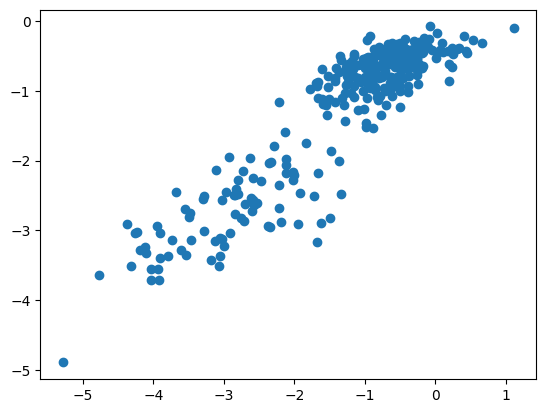

In [44]:
# scatterplot train_preds
plt.scatter(y_train, train_preds)

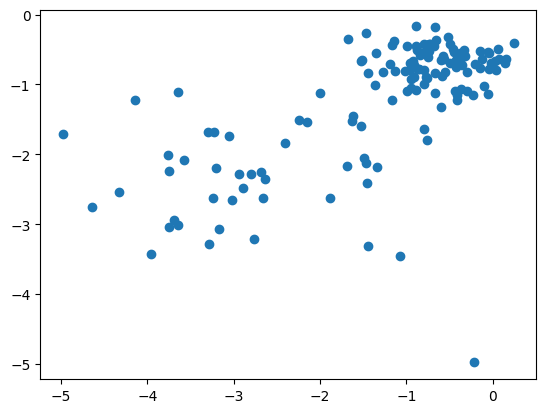

In [45]:
# scatterplot test preds
plt.scatter(y_test, test_preds)

# Try this as a standalone function

In [92]:
from refract.trainers import NNTrainer

In [93]:
# load data
logger.info("Loading feature data...")
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
feature_df.set_index("ccle_name", inplace=True)
feature_df.fillna(-1, inplace=True)

INFO:refract.trainers:Loading feature data...


In [94]:
logger.info("Loading response data...")
response_df = pd.read_csv(response_path)

# only keep cell lines we have features for
available_ccle_names = set(feature_df.index)
response_df = response_df[response_df["ccle_name"].isin(available_ccle_names)]

# drop culture column
response_df = response_df.drop(columns=["culture"])
# drop duplicates by ccle_name, keep first
response_df = response_df.drop_duplicates(subset=["ccle_name"], keep="first")


INFO:refract.trainers:Loading response data...


In [95]:
# START CV TRAIN
skf = KFold(n_splits=10, shuffle=True, random_state=42)
trainers = []
for i, (train_index, test_index) in enumerate(skf.split(response_df)):
    logger.info(f"Training fold {i}")
    response_train = response_df.iloc[train_index, :].reset_index(drop=True).copy()
    response_test = response_df.iloc[test_index, :].reset_index(drop=True).copy()

    # train one fold
    trainer = NNTrainer(
        response_train=response_train,
        response_test=response_test,
        feature_df=feature_df,
    )
    trainer.train()
    trainers.append(trainer)


INFO:refract.trainers:Training fold 0


Epoch [1/100], Train Loss: 2.4679, Val Loss: 1.4929
Epoch [2/100], Train Loss: 1.5174, Val Loss: 0.9331
Epoch [3/100], Train Loss: 1.1381, Val Loss: 0.9032
Epoch [4/100], Train Loss: 0.8046, Val Loss: 0.8269
Epoch [5/100], Train Loss: 0.8233, Val Loss: 0.8421
Epoch [6/100], Train Loss: 0.7787, Val Loss: 0.8836
Epoch [7/100], Train Loss: 0.6936, Val Loss: 0.8043
Epoch [8/100], Train Loss: 0.6687, Val Loss: 0.7180
Epoch [9/100], Train Loss: 0.7625, Val Loss: 0.7666
Epoch [10/100], Train Loss: 0.7570, Val Loss: 0.7177
Epoch [11/100], Train Loss: 0.7477, Val Loss: 0.7246
Epoch [12/100], Train Loss: 0.6659, Val Loss: 0.7465
Epoch [13/100], Train Loss: 0.6579, Val Loss: 0.7756
Epoch [14/100], Train Loss: 0.7478, Val Loss: 0.7171
Epoch [15/100], Train Loss: 0.5589, Val Loss: 0.6606
Epoch [16/100], Train Loss: 0.6278, Val Loss: 0.6415
Epoch [17/100], Train Loss: 0.6002, Val Loss: 0.6439
Epoch [18/100], Train Loss: 0.7231, Val Loss: 0.6912
Epoch [19/100], Train Loss: 0.5823, Val Loss: 0.6862
Ep

INFO:refract.trainers:Training fold 1


Fold correlation: 0.6338952072832393
Epoch [1/100], Train Loss: 2.3130, Val Loss: 1.3221
Epoch [2/100], Train Loss: 1.3445, Val Loss: 0.9565
Epoch [3/100], Train Loss: 1.1107, Val Loss: 0.8538
Epoch [4/100], Train Loss: 0.8722, Val Loss: 0.7196
Epoch [5/100], Train Loss: 1.0272, Val Loss: 0.8174
Epoch [6/100], Train Loss: 0.9124, Val Loss: 0.7382
Epoch [7/100], Train Loss: 0.6493, Val Loss: 0.6300
Epoch [8/100], Train Loss: 0.7153, Val Loss: 0.7770
Epoch [9/100], Train Loss: 0.7180, Val Loss: 0.7929
Epoch [10/100], Train Loss: 0.6605, Val Loss: 0.7267
Epoch [11/100], Train Loss: 0.6821, Val Loss: 0.6871
Epoch [12/100], Train Loss: 0.6884, Val Loss: 0.6690
Early stopping triggered


INFO:refract.trainers:Training fold 2


Fold correlation: 0.7594389719912019
Epoch [1/100], Train Loss: 2.3243, Val Loss: 1.3415
Epoch [2/100], Train Loss: 1.4188, Val Loss: 0.9327
Epoch [3/100], Train Loss: 1.1347, Val Loss: 0.7204
Epoch [4/100], Train Loss: 1.0058, Val Loss: 0.6639
Epoch [5/100], Train Loss: 0.9269, Val Loss: 0.6930
Epoch [6/100], Train Loss: 0.8806, Val Loss: 0.6546
Epoch [7/100], Train Loss: 0.9179, Val Loss: 0.7243
Epoch [8/100], Train Loss: 0.6862, Val Loss: 0.6488
Epoch [9/100], Train Loss: 0.6304, Val Loss: 0.6237
Epoch [10/100], Train Loss: 0.7283, Val Loss: 0.7191
Epoch [11/100], Train Loss: 0.6664, Val Loss: 0.7211
Epoch [12/100], Train Loss: 0.6128, Val Loss: 0.6407
Epoch [13/100], Train Loss: 0.6597, Val Loss: 0.7240
Epoch [14/100], Train Loss: 0.5947, Val Loss: 0.6550
Early stopping triggered


INFO:refract.trainers:Training fold 3


Fold correlation: 0.6650916496020105
Epoch [1/100], Train Loss: 2.7164, Val Loss: 2.1772
Epoch [2/100], Train Loss: 1.5935, Val Loss: 0.8458
Epoch [3/100], Train Loss: 1.1315, Val Loss: 0.9661
Epoch [4/100], Train Loss: 0.9383, Val Loss: 0.7375
Epoch [5/100], Train Loss: 0.9818, Val Loss: 0.8892
Epoch [6/100], Train Loss: 0.7777, Val Loss: 0.6565
Epoch [7/100], Train Loss: 0.7131, Val Loss: 0.9116
Epoch [8/100], Train Loss: 0.7958, Val Loss: 0.8381
Epoch [9/100], Train Loss: 0.7078, Val Loss: 0.6829
Epoch [10/100], Train Loss: 0.6879, Val Loss: 0.7013
Epoch [11/100], Train Loss: 0.7365, Val Loss: 0.8706
Early stopping triggered


INFO:refract.trainers:Training fold 4


Fold correlation: 0.7037297748136498
Epoch [1/100], Train Loss: 1.8563, Val Loss: 1.5391
Epoch [2/100], Train Loss: 1.1687, Val Loss: 0.9485
Epoch [3/100], Train Loss: 0.9966, Val Loss: 1.1190
Epoch [4/100], Train Loss: 0.9670, Val Loss: 0.9135
Epoch [5/100], Train Loss: 0.6955, Val Loss: 0.8195
Epoch [6/100], Train Loss: 0.8021, Val Loss: 1.0417
Epoch [7/100], Train Loss: 0.7298, Val Loss: 0.8741
Epoch [8/100], Train Loss: 0.5962, Val Loss: 0.8979
Epoch [9/100], Train Loss: 0.6767, Val Loss: 0.9299
Epoch [10/100], Train Loss: 0.6312, Val Loss: 0.8202
Early stopping triggered


INFO:refract.trainers:Training fold 5


Fold correlation: 0.7830934427963029
Epoch [1/100], Train Loss: 2.0690, Val Loss: 1.1173
Epoch [2/100], Train Loss: 1.1342, Val Loss: 0.7198
Epoch [3/100], Train Loss: 0.8743, Val Loss: 0.6977
Epoch [4/100], Train Loss: 1.0162, Val Loss: 0.6555
Epoch [5/100], Train Loss: 0.8601, Val Loss: 0.6922
Epoch [6/100], Train Loss: 0.8330, Val Loss: 0.6425
Epoch [7/100], Train Loss: 0.6713, Val Loss: 0.6538
Epoch [8/100], Train Loss: 0.6678, Val Loss: 0.7226
Epoch [9/100], Train Loss: 0.7522, Val Loss: 0.6487
Epoch [10/100], Train Loss: 0.6398, Val Loss: 0.7049
Epoch [11/100], Train Loss: 0.7151, Val Loss: 0.6142
Epoch [12/100], Train Loss: 0.6132, Val Loss: 0.6770
Epoch [13/100], Train Loss: 0.6282, Val Loss: 0.6400
Epoch [14/100], Train Loss: 0.6141, Val Loss: 0.7169
Epoch [15/100], Train Loss: 0.5842, Val Loss: 0.6066
Epoch [16/100], Train Loss: 0.4750, Val Loss: 0.6470
Epoch [17/100], Train Loss: 0.5880, Val Loss: 0.6930
Epoch [18/100], Train Loss: 0.5534, Val Loss: 0.7344
Epoch [19/100], Tr

INFO:refract.trainers:Training fold 6


Fold correlation: 0.6440461856078883
Epoch [1/100], Train Loss: 2.8461, Val Loss: 1.9553
Epoch [2/100], Train Loss: 1.5506, Val Loss: 0.9490
Epoch [3/100], Train Loss: 1.1292, Val Loss: 0.9128
Epoch [4/100], Train Loss: 0.9148, Val Loss: 0.8256
Epoch [5/100], Train Loss: 0.8078, Val Loss: 0.6817
Epoch [6/100], Train Loss: 0.7465, Val Loss: 0.7396
Epoch [7/100], Train Loss: 0.6932, Val Loss: 0.6264
Epoch [8/100], Train Loss: 0.7967, Val Loss: 0.6494
Epoch [9/100], Train Loss: 0.5926, Val Loss: 0.6185
Epoch [10/100], Train Loss: 0.7121, Val Loss: 0.6791
Epoch [11/100], Train Loss: 0.7239, Val Loss: 0.6214
Epoch [12/100], Train Loss: 0.5976, Val Loss: 0.6455
Epoch [13/100], Train Loss: 0.5418, Val Loss: 0.5965
Epoch [14/100], Train Loss: 0.5735, Val Loss: 0.5895
Epoch [15/100], Train Loss: 0.5855, Val Loss: 0.6090
Epoch [16/100], Train Loss: 0.5692, Val Loss: 0.6448
Epoch [17/100], Train Loss: 0.5702, Val Loss: 0.5698
Epoch [18/100], Train Loss: 0.5249, Val Loss: 0.6378
Epoch [19/100], Tr

INFO:refract.trainers:Training fold 7


Fold correlation: 0.7245066876885051
Epoch [1/100], Train Loss: 2.2261, Val Loss: 2.1270
Epoch [2/100], Train Loss: 1.3940, Val Loss: 1.0689
Epoch [3/100], Train Loss: 1.1306, Val Loss: 1.2821
Epoch [4/100], Train Loss: 0.9214, Val Loss: 0.9181
Epoch [5/100], Train Loss: 0.8107, Val Loss: 0.9306
Epoch [6/100], Train Loss: 0.7043, Val Loss: 0.8239
Epoch [7/100], Train Loss: 0.6797, Val Loss: 1.0414
Epoch [8/100], Train Loss: 0.8619, Val Loss: 0.7745
Epoch [9/100], Train Loss: 0.6170, Val Loss: 0.7636
Epoch [10/100], Train Loss: 0.7186, Val Loss: 0.8686
Epoch [11/100], Train Loss: 0.6714, Val Loss: 0.7330
Epoch [12/100], Train Loss: 0.7087, Val Loss: 0.8924
Epoch [13/100], Train Loss: 0.6289, Val Loss: 0.7192
Epoch [14/100], Train Loss: 0.5527, Val Loss: 0.7513
Epoch [15/100], Train Loss: 0.5509, Val Loss: 0.7731
Epoch [16/100], Train Loss: 0.5438, Val Loss: 0.7504
Epoch [17/100], Train Loss: 0.5686, Val Loss: 0.8450
Epoch [18/100], Train Loss: 0.6185, Val Loss: 0.6307
Epoch [19/100], Tr

INFO:refract.trainers:Training fold 8


Fold correlation: 0.767168104134871
Epoch [1/100], Train Loss: 2.2600, Val Loss: 0.9795
Epoch [2/100], Train Loss: 1.3507, Val Loss: 0.5724
Epoch [3/100], Train Loss: 0.9543, Val Loss: 0.6158
Epoch [4/100], Train Loss: 0.8503, Val Loss: 0.5161
Epoch [5/100], Train Loss: 0.7448, Val Loss: 0.5177
Epoch [6/100], Train Loss: 0.8424, Val Loss: 0.5477
Epoch [7/100], Train Loss: 0.7916, Val Loss: 0.6862
Epoch [8/100], Train Loss: 0.6473, Val Loss: 0.4422
Epoch [9/100], Train Loss: 0.5912, Val Loss: 0.5006
Epoch [10/100], Train Loss: 0.6596, Val Loss: 0.5914
Epoch [11/100], Train Loss: 0.5585, Val Loss: 0.5154
Epoch [12/100], Train Loss: 0.5930, Val Loss: 0.5139
Epoch [13/100], Train Loss: 0.5019, Val Loss: 0.5009
Early stopping triggered


INFO:refract.trainers:Training fold 9


Fold correlation: 0.5549138036301453
Epoch [1/100], Train Loss: 2.8757, Val Loss: 2.4015
Epoch [2/100], Train Loss: 1.6287, Val Loss: 0.8913
Epoch [3/100], Train Loss: 1.3923, Val Loss: 0.9753
Epoch [4/100], Train Loss: 1.2800, Val Loss: 1.1084
Epoch [5/100], Train Loss: 0.9361, Val Loss: 0.7487
Epoch [6/100], Train Loss: 0.9163, Val Loss: 0.7532
Epoch [7/100], Train Loss: 0.8033, Val Loss: 0.7439
Epoch [8/100], Train Loss: 0.8022, Val Loss: 0.7344
Epoch [9/100], Train Loss: 0.8311, Val Loss: 0.7400
Epoch [10/100], Train Loss: 0.8192, Val Loss: 0.7309
Epoch [11/100], Train Loss: 0.8034, Val Loss: 0.8219
Epoch [12/100], Train Loss: 0.6744, Val Loss: 0.7134
Epoch [13/100], Train Loss: 0.8286, Val Loss: 0.7921
Epoch [14/100], Train Loss: 0.6563, Val Loss: 0.6534
Epoch [15/100], Train Loss: 0.7520, Val Loss: 0.6515
Epoch [16/100], Train Loss: 0.7857, Val Loss: 0.7956
Epoch [17/100], Train Loss: 0.6639, Val Loss: 0.5931
Epoch [18/100], Train Loss: 0.7045, Val Loss: 0.8242
Epoch [19/100], Tr

In [96]:
# Get the overall performance
all_pred = []
all_true = []
for trainer in trainers:
    all_pred.extend(trainer.y_test_pred)
    all_true.extend(trainer.y_test)

In [97]:
# print pearson correlation
r, p = pearsonr(all_true, all_pred)
print(f"Pearson correlation: {r:.3f}, p-value: {p:.3f}")

Pearson correlation: 0.685, p-value: 0.000


# Here's an idea: pretraining on the full dataset

In [99]:
import glob

In [100]:
# get all responses
all_response_files = glob.glob("/scratch/users/nphill22/projects/corsello_lab/20240313_prism_final_reruns/data/features/responses/*")

In [ ]:
# 